# Analyze and visualize last.fm listening history

To see this analysis live, check out my article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/)

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

In [106]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Myriad Pro'
plt.rcParams['text.color'] = '#555555'

print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [107]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [108]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [166]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
The Offspring        783
Linkin Park          731
Placebo              682
Mumford & Sons       611
Within Temptation    538
Name: play_count, dtype: int64

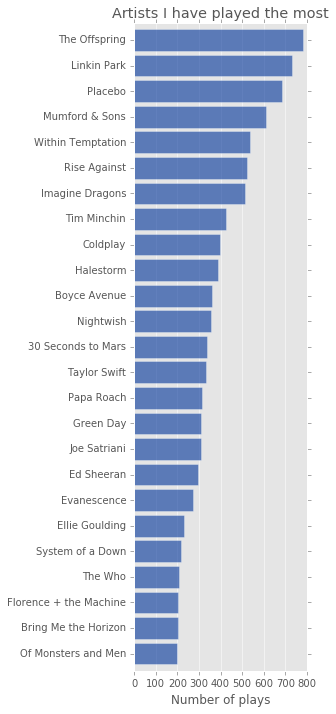

In [183]:
ax = artists_most.sort_values(ascending=True).plot(kind='barh', figsize=[6, 10], width=0.85, alpha=0.6, color='#003399', edgecolor='w', grid=False)

ax.xaxis.grid(True)
#ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right')

ax.set_title('Artists I have played the most')
ax.set_ylabel('')
ax.set_xlabel('Number of plays')

ax.set_position([0.50, 0.05, 0.9-0.5, 0.95-0.05])

plt.savefig('images/lastfm-artists-played-most-h.png', dpi=96)

## Top tracks

In [168]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')
index = tracks_most.apply(lambda x: u'{}\n{}'.format(x['artist'], x['track']), axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

Linkin Park\nIridescent            64
Tim Minchin\nThe Fence             54
Mumford & Sons\nI Gave You All     45
Placebo\nBright Lights             42
The Police\nMessage in a Bottle    42
Name: play_count, dtype: int64

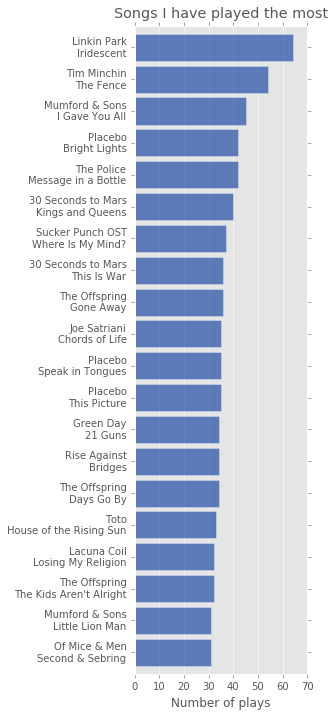

In [180]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.85, alpha=0.6, color='#003399', edgecolor='w', grid=False)
ax.xaxis.grid(True)
#for label in ax.get_xticklabels():
#    label.set_fontproperties(ticks_font_h)
#for label in ax.get_yticklabels():
#    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays')
ax.set_ylabel('')
ax.set_title('Songs I have played the most', y=1.005)

ax.set_position([0.50, 0.05, 0.9-0.5, 0.95-0.05])

plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96)
plt.show()

## Top albums

In [176]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')
index = albums_most.apply(lambda x: u'{}\n{}'.format(x['artist'], x['album']), axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

Mumford & Sons\nBabel               306
Imagine Dragons\nSmoke + Mirrors    263
30 Seconds to Mars\nThis Is War     260
Tim Minchin\nLive at the O2         238
Placebo\nBattle for the Sun         226
Name: play_count, dtype: int64

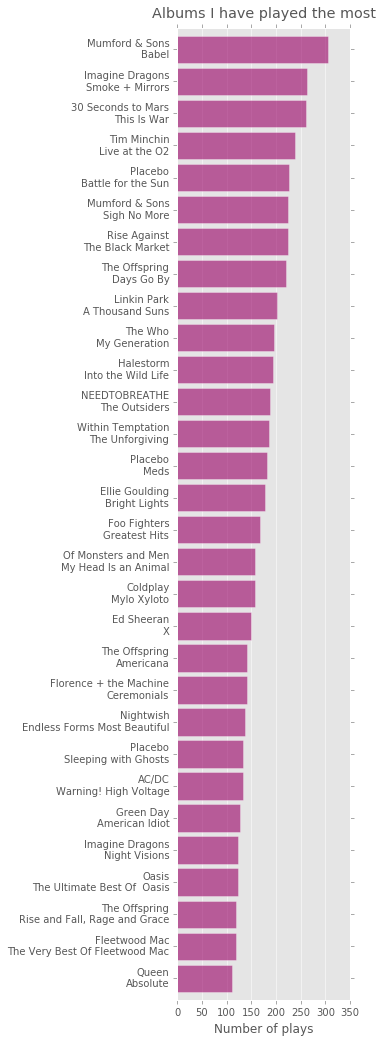

In [179]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6, 15], width=0.85, alpha=0.6, color='#990066', edgecolor='w', grid=False)
ax.xaxis.grid(True)
#for label in ax.get_xticklabels():
#    label.set_fontproperties(ticks_font_h)
#for label in ax.get_yticklabels():
#    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays')
ax.set_ylabel('')
ax.set_title('Albums I have played the most', y=1.005)

ax.set_position([0.50, 0.05, 0.9-0.5, 0.95-0.05])

plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96)
plt.show()

## All-time scrobbles

In [115]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print '{:,} total scrobbles'.format(len(scrobbles))
print '{:,} total artists'.format(len(scrobbles['artist'].unique()))

13,446 total scrobbles
521 total artists


According to the last.fm web site, I have ~13,970 scrobbles. This API endpoint seems to miss the ones from before 2012.

In [116]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'], dayfirst=True)

In [117]:
# functions to convert UTC to Pacific time zone and extract date/time elements
convert_tz = lambda x: x.to_datetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('GMT'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [118]:
# parse out date and time elements as pacific time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
#scrobbles = scrobbles.drop(labels=['timestamp'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,datetime,timestamp,year,month,day,hour,dow
0,Leslie Odom Jr.,NaN,Hamilton (Original Broadway Cast Recording),NaN,Dear Theodosia,NaN,20/03/2017 15:42,2017-03-20 15:42:00,2017,2017-03,20,15,0
1,Original Broadway Cast Of Hamilton,NaN,Hamilton (Original Broadway Cast Recording),NaN,Yorktown (The World Turned Upside Down),NaN,20/03/2017 15:38,2017-03-20 15:38:00,2017,2017-03,20,15,0
2,Bring Me the Horizon,074e3847-f67f-49f9-81f1-8c8cea147e8e,That's The Spirit,NaN,What You Need,NaN,20/03/2017 08:28,2017-03-20 08:28:00,2017,2017-03,20,8,0
3,Coldplay,cc197bad-dc9c-440d-a5b5-d52ba2e14234,A Rush of Blood to the Head,219b202d-290e-3960-b626-bf852a63bc50,God Put a Smile Upon Your Face,fe9caa6d-00b3-4896-ba6e-32d9e5ba2118,20/03/2017 08:23,2017-03-20 08:23:00,2017,2017-03,20,8,0
4,Of Monsters and Men,9e103f85-7af7-41d7-b83b-49ba8f0c5abf,Beneath The Skin (Deluxe),NaN,I of the Storm,NaN,20/03/2017 08:19,2017-03-20 08:19:00,2017,2017-03,20,8,0


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

# Exploration depth by artist

Number of unique tracks heard by each artist

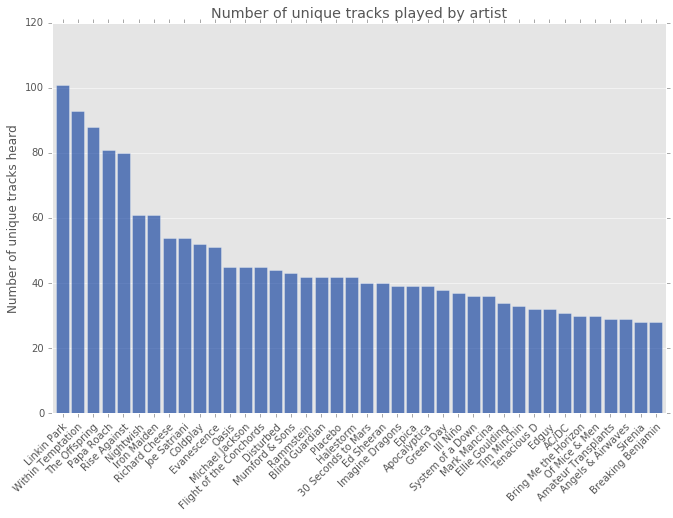

In [119]:
ax = scrobbles \
    .groupby(['artist', 'track']) \
    .size() \
    .groupby(level=0) \
    .size() \
    .sort_values(ascending=False) \
    .head(40) \
    .plot(kind='bar', figsize=[11, 7], width=0.85, alpha=0.6, color='#003399', edgecolor='w', grid=False)
    
ax.yaxis.grid(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode='anchor', ha='right')

plt.gcf().set_size_inches(11, 7)
plt.title('Number of unique tracks played by artist')
plt.ylabel('Number of unique tracks heard')
plt.xlabel('')

plt.savefig('images/lastfm-uniqe-tracks-played-per-artist-most-h.png', dpi=96, bbox_inches='tight')

## Timeseries analysis

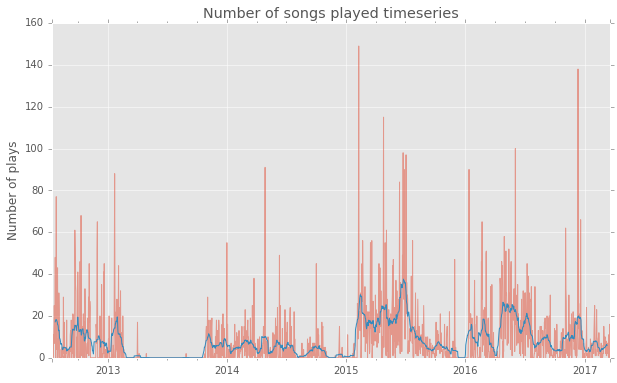

In [120]:
scrobbles.set_index('timestamp').resample('d').size().plot(alpha=.5)
scrobbles.set_index('timestamp').resample('d').size().rolling(20).mean().shift(-10).plot()
plt.gcf().set_size_inches(10,6)
plt.gca().set_ylabel('Number of plays')
plt.gca().set_xlabel('')
plt.gca().set_title('Number of songs played timeseries')
plt.savefig('images/lastfm-songs-played-timeseries.png', dpi=96, bbox_inches='tight')

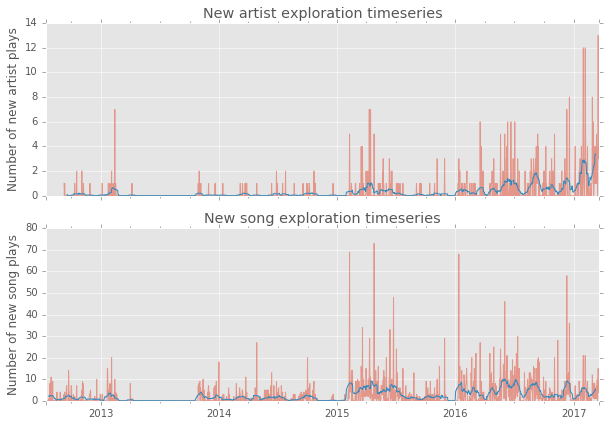

In [121]:
# Unique artist timeseries
ax1 = plt.subplot(2,1,1)
scrobbles.groupby('artist').first().set_index('timestamp').resample('d').size().plot(alpha=.5)
scrobbles.groupby('artist').first().set_index('timestamp').resample('d').size().rolling(20).mean().shift(-10).plot()
plt.gca().set_ylabel('Number of new artist plays')
plt.gca().set_xlabel('')
plt.gca().set_title('New artist exploration timeseries')

ax2= plt.subplot(2,1,2, sharex=ax1)
# Unique sond exploration timeseries
scrobbles.groupby(['artist', 'track']).first().set_index('timestamp').resample('d').size().plot(alpha=.5)
scrobbles.groupby(['artist', 'track']).first().set_index('timestamp').resample('d').size().rolling(20).mean().shift(-10).plot()
plt.gca().set_ylabel('Number of new song plays')
plt.gca().set_xlabel('')
plt.gca().set_title('New song exploration timeseries')

plt.gcf().set_size_inches(10,6)
plt.tight_layout(rect=[0, 0, .85, 1])
plt.savefig('images/lastfm-new-artists-and-tracks-timeseries.png', dpi=96, bbox_inches='tight')

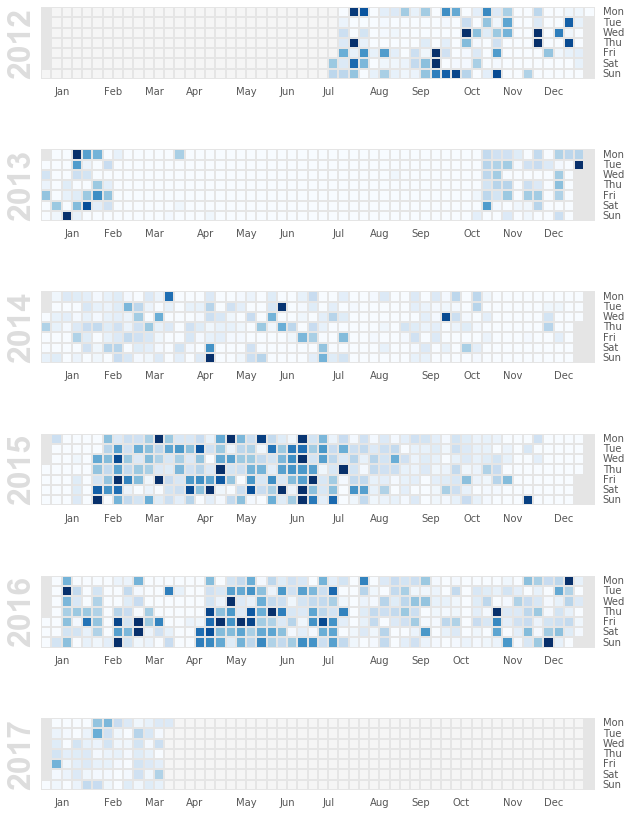

In [122]:
# Calendar view
import calmap

calmap.calendarplot(scrobbles.set_index('timestamp').resample('d').size(),
                    cmap='Blues',
                    yearlabel_kws={'color' : '#DDDDDD'},
                    vmax=50)
plt.gcf().set_size_inches(10,12)
plt.tight_layout()
plt.savefig('images/lastfm-activity-calendar-view.png', dpi=96, bbox_inches='tight')

## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

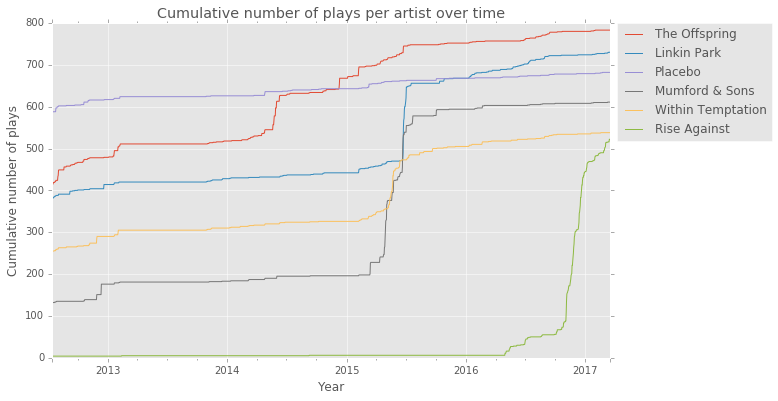

In [123]:
# get one color per artist
n = 6

top_artist_timeseries_over_observed_timeperiod = scrobbles[scrobbles.artist.isin(artists_most.head(n).index)].groupby(['timestamp', 'artist']).size().unstack().resample('d').sum().fillna(0).cumsum()
starting_offset = artists_most.head(n) - top_artist_timeseries_over_observed_timeperiod.iloc[-1,:].T
(top_artist_timeseries_over_observed_timeperiod + starting_offset).loc[:,artists_most.head(n).index].plot(alpha=1.0)

plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Cumulative number of plays')
plt.gca().set_title('Cumulative number of plays per artist over time')
plt.gcf().set_size_inches(10,6)
plt.gca().legend(loc='upper right', bbox_to_anchor=(1.30,1.017))
plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [124]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

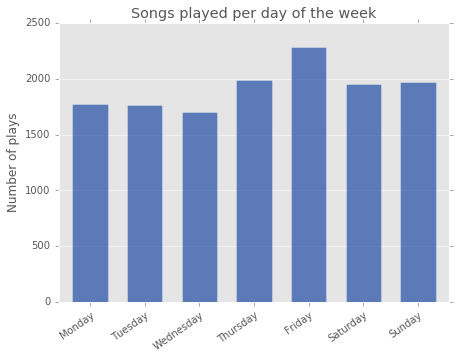

In [125]:
ax = dow_counts.plot(kind='bar', figsize=[7, 5], width=0.65, alpha=0.6, color='#003399', edgecolor='w', grid=False)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right')
#for label in ax.get_yticklabels():
#    label.set_fontproperties(ticks_font)

ax.set_title('Songs played per day of the week')
ax.set_xlabel('')
ax.set_ylabel('Number of plays')

plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

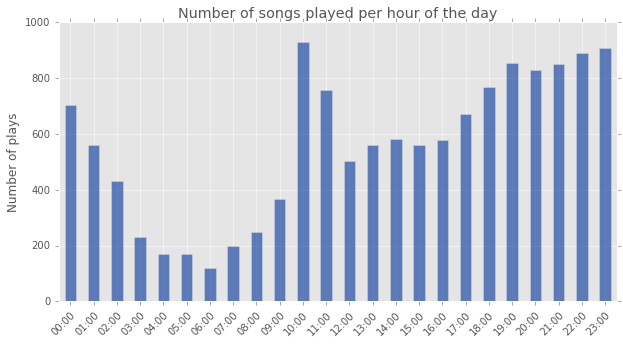

In [126]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='bar', figsize=[10, 5], alpha=0.6, color='#003399', grid=True)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylabel('Number of plays')
ax.set_xlabel('')
ax.set_title('Number of songs played per hour of the day')

plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [127]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

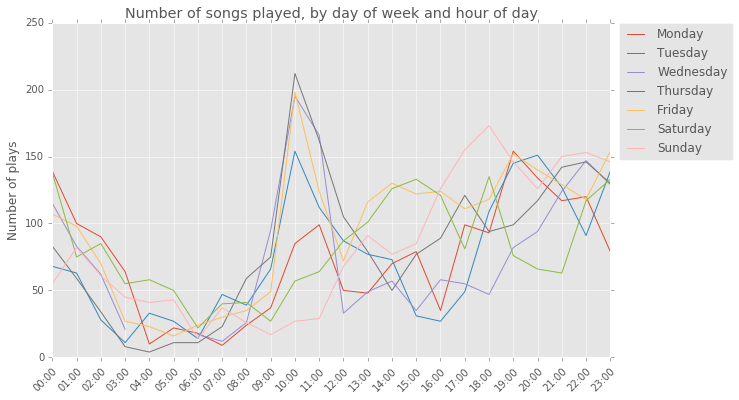

In [128]:
# get one color per day of week
colors = get_colors('Dark2', n=len(day_numbers), start=0.05, stop=0.95, reverse=True)

#fig, ax = plt.subplots(figsize=[10, 6])
weekday_hour_counts.unstack(level=0).rename(columns=day_names).plot()
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
plt.gca().set_xticks(range(len(xlabels)))
plt.gca().set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

plt.gca().yaxis.grid(True)
plt.gca().set_ylabel('Number of plays')
plt.gca().set_xlabel('')
plt.gca().set_title('Number of songs played, by day of week and hour of day')
plt.gca().legend(loc='upper right', bbox_to_anchor=(1.23,1.017))
plt.gcf().set_size_inches(10,6)

plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [24]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2015])]
len(scrobbles_year)

5356

In [25]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,Imagine Dragons,402
2,Mumford & Sons,398
3,Taylor Swift,300
4,David Mitchell,257
5,Linkin Park,226
6,Halestorm,211
7,Boyce Avenue,194
8,Within Temptation,179
9,Ed Sheeran,165
10,NEEDTOBREATHE,147


In [26]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,Mumford & Sons,Where Are You Now,29
2,Mumford & Sons,The Boxer,28
3,Mumford & Sons,Lover of the Light,26
4,Imagine Dragons,"Who We Are (From ""The Hunger Games: Catching F...",25
5,NEEDTOBREATHE,Let Us Love,23
6,Imagine Dragons,Second Chances,23
7,Imagine Dragons,Shots,23
8,Mumford & Sons,Hopeless Wanderer,22
9,Mumford & Sons,Ghosts That We Knew,22
10,zwieR.Z.,Breaking The Habit,22


In [27]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile(u'\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub(u'', x))
albums_year.head(10)

,artist,album,play count
1,Mumford & Sons,Babel,276
2,Imagine Dragons,Smoke + Mirrors,263
3,NEEDTOBREATHE,The Outsiders,146
4,Halestorm,Into the Wild Life,139
5,zwieR.Z.,You Did It To Yourself,121
6,Of Monsters and Men,My Head Is an Animal,120
7,Ed Sheeran,x,118
8,Nightwish,Endless Forms Most Beautiful,110
9,Foo Fighters,Greatest Hits,98
10,Linkin Park,The Hunting Party,83


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [28]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2014-02'])]
len(scrobbles_month)

173

In [29]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,George R. R. Martin,67
2,Coldplay,20
3,Halestorm,20
4,Imagine Dragons,18
5,AC/DC,17
6,The Beatles,7
7,Dropkick Murphys,7
8,The Killers,2
9,Eric Clapton,2
10,Within Temptation,2


In [30]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,George R. R. Martin,Jon,17
2,George R. R. Martin,Daenerys,15
3,George R. R. Martin,Tyrion,10
4,George R. R. Martin,Reek,8
5,George R. R. Martin,Davos,7
6,George R. R. Martin,The Windblown,5
7,Imagine Dragons,Tiptoe,3
8,Dropkick Murphys,Climbing a Chair to Bed,2
9,Imagine Dragons,Nothing Left to Say/Rocks,2
10,Coldplay,Up with the Birds,2


In [31]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,George R. R. Martin,A Dance with Dragons,67
2,Imagine Dragons,Night Visions,18
3,AC/DC,Warning! High Voltage (Greatest Hits) CD1,17
4,Halestorm,Halestorm,14
5,Coldplay,X & Y (Proper Retail),11
6,Coldplay,Mylo Xyloto,9
7,Dropkick Murphys,Going Out in Style,7
8,Halestorm,The Strange Case Of...,4
9,The Killers,Day & Age,2
10,Led Zeppelin,Greatest Hits Disc 1,1


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [170]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('Tim Minchin')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,datetime,year,month,day,hour,dow,timestamp
1527,Tim Minchin,2dc758d7-6776-45d1-b537-484249bd265e,So Rock,2e2ee8bc-64ba-49bf-87a9-bc3ec6ef4f3f,If You Really Loved Me,abebf30a-3bb1-4899-b897-6cd207be9c64,29/02/2016 19:35,2016,2016-02,29,19,0,2016-02-29 19:35:00
1800,Tim Minchin,2dc758d7-6776-45d1-b537-484249bd265e,Darkside,53ac3a14-ebec-44c2-857e-b2a383778cbf,Not Perfect,3eaf3a4f-d9ff-4f59-a7cd-48a32e2a70f6,05/02/2016 20:34,2016,2016-02,5,20,4,2016-02-05 20:34:00
1915,Tim Minchin,2dc758d7-6776-45d1-b537-484249bd265e,Live at the O2,b0d08f06-eab1-41ca-8b94-6e3036085e4f,Dark Side,c4b7dc44-d9ac-497a-907f-eedb6a1bd304,28/01/2016 21:06,2016,2016-01,28,21,3,2016-01-28 21:06:00
1929,Tim Minchin,2dc758d7-6776-45d1-b537-484249bd265e,Live at the O2,b0d08f06-eab1-41ca-8b94-6e3036085e4f,Lullaby,9a7cdb75-295c-458a-a493-50e0a6da687c,23/01/2016 21:43,2016,2016-01,23,21,5,2016-01-23 21:43:00
1957,Tim Minchin,2dc758d7-6776-45d1-b537-484249bd265e,Tim Minchin & The Heritage Orchestra,NaN,Cheese,e9267cd1-8985-499d-96ed-37700bc3b667,20/01/2016 21:04,2016,2016-01,20,21,2,2016-01-20 21:04:00


In [171]:
# when were the last 5 times I played something off of Double Nickels on the Dime?
scrobbles[scrobbles['album'].fillna('').str.contains('Americana')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,datetime,year,month,day,hour,dow,timestamp
2524,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,Walla Walla,d890023d-d022-4d60-9605-a64b17789f81,10/10/2015 12:55,2015,2015-10,10,12,5,2015-10-10 12:55:00
3897,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,Pretty Fly (For a White Guy),45bf75f9-c169-47c7-babc-4fd9489bbdd8,25/06/2015 00:39,2015,2015-06,25,0,3,2015-06-25 00:39:00
3898,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,Pretty Fly (For a White Guy),45bf75f9-c169-47c7-babc-4fd9489bbdd8,25/06/2015 00:36,2015,2015-06,25,0,3,2015-06-25 00:36:00
3899,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,Pretty Fly (For a White Guy),45bf75f9-c169-47c7-babc-4fd9489bbdd8,24/06/2015 23:38,2015,2015-06,24,23,2,2015-06-24 23:38:00
3903,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,Pretty Fly (For a White Guy),45bf75f9-c169-47c7-babc-4fd9489bbdd8,24/06/2015 22:29,2015,2015-06,24,22,2,2015-06-24 22:29:00


In [172]:
# when were the last 5 times I played Personality Crisis?
scrobbles[scrobbles['track'].str.contains('No Brakes')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,datetime,year,month,day,hour,dow,timestamp
3913,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,No Brakes,4be0dc18-002c-46f0-a5e9-a01e1e33b716,24/06/2015 21:57,2015,2015-06,24,21,2,2015-06-24 21:57:00
7001,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,No Brakes,4be0dc18-002c-46f0-a5e9-a01e1e33b716,08/02/2015 09:10,2015,2015-02,8,9,6,2015-02-08 09:10:00
7254,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,No Brakes,4be0dc18-002c-46f0-a5e9-a01e1e33b716,11/12/2014 00:22,2014,2014-12,11,0,3,2014-12-11 00:22:00
7891,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,No Brakes,4be0dc18-002c-46f0-a5e9-a01e1e33b716,29/05/2014 23:02,2014,2014-05,29,23,3,2014-05-29 23:02:00
9319,The Offspring,23a03e33-a603-404e-bcbf-2c00159d7067,Americana,c716d82d-6c6e-390c-813b-624728d67991,No Brakes,4be0dc18-002c-46f0-a5e9-a01e1e33b716,01/02/2013 23:30,2013,2013-02,1,23,4,2013-02-01 23:30:00


## Characteristics of artists' names

Text analysis of artist name strings

In [175]:
# remove 'The ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.uppercase]]

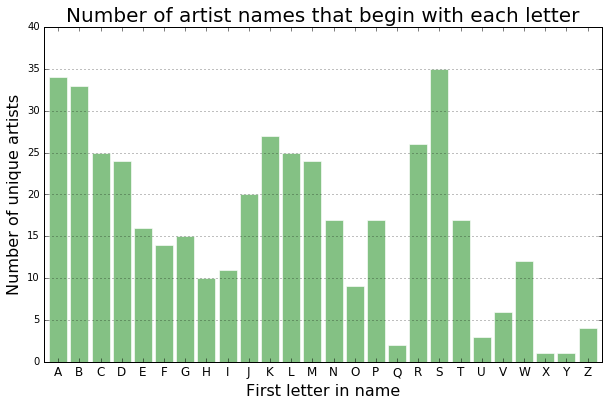

In [176]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.85, alpha=0.6, color='#339933', edgecolor='w')
ax.yaxis.grid(True)
ax.set_ylim((0, 40))
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [177]:
# which artist names begin with the letter 'O'?
pd.Series(artists_clean[artists_clean.str.upper().str.startswith('O')].unique())

0          Of Mice & Men
1         Our Last Night
2    Of Monsters and Men
3          Ozzy Osbourne
4            OneRepublic
5                  Oasis
6              Offspring
7         Obadiah Parker
8                OCReMix
dtype: object

In [178]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Michael     2
Madelyn     1
Marc        1
Matthew     1
Miranda     1
Mumford     1
Muffin      1
Mortal      1
Mika        1
Mudvayne    1
Muse        1
Mana        1
Mr.         1
Matchbox    1
Moby        1
dtype: int64

In [179]:
# what are the most common first words in all the artist names?
pd.Series(artists_clean.unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

john        6
nine        2
kelly       2
white       2
seether     2
eric        2
michael     2
van         2
amy         2
ryan        2
black       2
daniel      2
carrie      2
ludovico    2
shakira     2
dtype: int64

In [180]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','and','in','for','la','de']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

john         8
day          4
amy          3
van          3
green        2
daniel       2
town         2
project      2
nine         2
anastacia    2
my           2
heart        2
crazy        2
james        2
shakira      2
dtype: int64

In [181]:
# what is the longest artist name?
print max(artists_clean, key=len)

Carrie Underwood-sOngIrooni21.Net & sOngIrooni.Net


In [182]:
# what is the distribution of lengths of artist names (number of characters)?
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:51].reindex(range(51), fill_value=0)

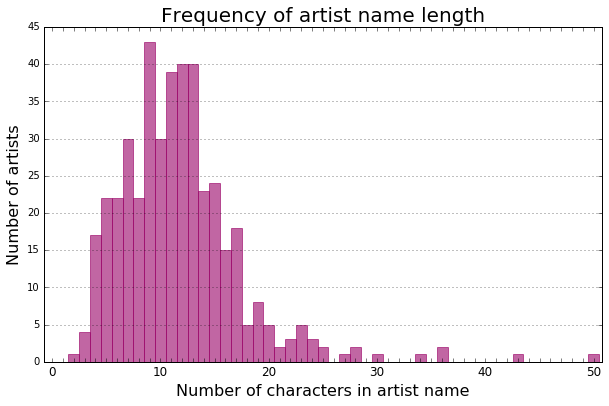

In [183]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066')

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()